## Food Vision - this project based on kaggle competition dataset: https://www.kaggle.com/datasets/dansbecker/food-101

## Dataset contains images of food, orginized by type of food, it was used in the paper "Food-101 - Mining Discriminative Components with Random Forest" by Lukas Bossard, Matthieu Guillaumin Luc Van Gool where model has achived average of 50.76% accuracy. 

## In this project I will try to achieve higher accuracy on food images classification using CNN model.


### Let's begin with importing important libraries we need to start this project

In [4]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random
import os


In [ ]:
print(tf.__version__)

2.12.0


### As the initial data exploration, I have picked 10 percent of the dataset from kaggle competition to start our modeling processes

In [ ]:
unzip_data("/content/drive/MyDrive/datasets/Food-Vision/10_percent/101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

#### Double check how many images our folder contains using helper funtion `walk_through_dir`

In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classe

#### View random image

In [ ]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


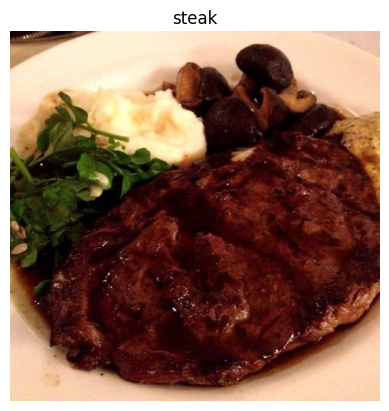

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class="steak")

#### Set up global variables

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

Let's use `image_dataset_from_driectory` since this function turns images and labels into `tf.data.Dataset` where we can pass it to our future models directly

In [ ]:
# Setup intputs
train_data_10_percent = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#### Let's build simple convolutional neural network model to see how it will perform with our dataset

In [ ]:
# Setup simple model

# For re-producablity set up seed
set_seed(42)

simple_model = Sequential([
    layers.Conv2D(
        filters=10,
        kernel_size=3,
        activation='relu',
        input_shape=(*IMAGE_SIZE, 3)
    ),
    layers.MaxPool2D(pool_size=2, padding='valid'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(len(train_data_10_percent.class_names), activation='softmax')
])

simple_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

simple_model_history = simple_model.fit(
    train_data_10_percent,
    epochs=3,
    validation_data=test_data
)

Epoch 1/3
237/237 [==============================] - 100s 367ms/step - loss: 19.0319 - accuracy: 0.0132 - val_loss: 4.6550 - val_accuracy: 0.0109
Epoch 2/3
237/237 [==============================] - 76s 319ms/step - loss: 4.1743 - accuracy: 0.1278 - val_loss: 4.8738 - val_accuracy: 0.0118
Epoch 3/3
237/237 [==============================] - 71s 300ms/step - loss: 3.1864 - accuracy: 0.3199 - val_loss: 5.6986 - val_accuracy: 0.0166


In [ ]:
# Check out the layers in our model
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 conv2d_5 (Conv2D)           (None, 107, 107, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 28090)             0

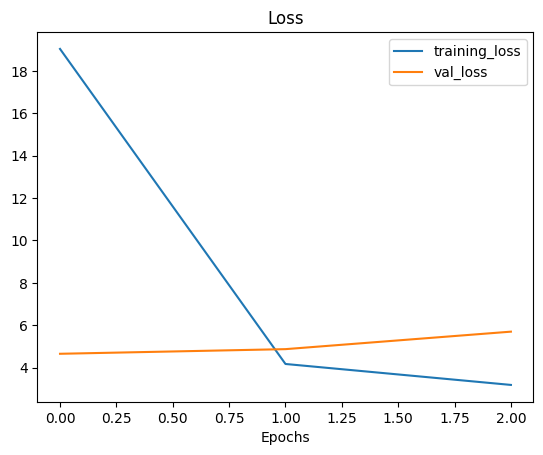

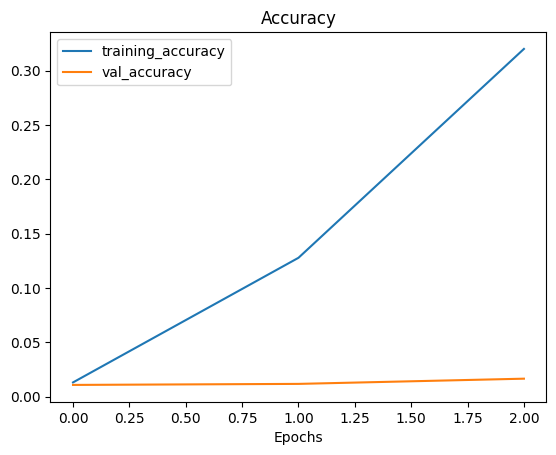

In [ ]:
# Plot loss and accuracy curves for our simple model
plot_loss_curves(simple_model_history)

#### As we can expect our simple model having a hard time to learn from given dataset with simple 3 Conv2D and 2 MaxPool2D layers. Next I will add data augmentation to our simple model in functional format

In [ ]:
# Define the pre-processing steps
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values between 0 and 1
)

test_datagen = ImageDataGenerator(rescale=1/255.)

# Load the data using the pre-processing steps
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE)

In [ ]:
# Setup simple model with data augmentation

# Define the model
simple_model_with_da = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(101, activation='softmax')
])

# Compile the model
simple_model_with_da.compile(
    optimizer=Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model with pre-processed data
simple_model_with_da_history = simple_model_with_da.fit(
    train_generator, 
    epochs=5,
    validation_data=test_generator
)

In [ ]:
# Plot loss and accuracy curves for our simple model with data augmentation
plot_loss_curves(simple_model_with_da_history)

#### Model still not performing better compare to previous model, however we have room to improve using transfer learning method with efficientnetb0 and check all the metrics to make sure if I can use it for my application.

I will use mix precision for trainig to increase efficiency, however we need to make sure if Tesla T4 is available for us

In [ ]:
# Check GPU

!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-565bca31-8262-f38e-06b7-e175ab96dc67)


#### Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/catalog/overview#all_datasets

In [1]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [2]:
# List all available datasets
datasets_list = tfds.list_builders() # get all avaiable datasets in TFDS
print('food101' in datasets_list)

True


In [3]:
# Load in the data (takes 5-6 minutes in Colab)
(train_data, test_data), ds_info = tfds.load(
    name='food101', 
    split=["train", 'validation'], 
    shuffle_files=True, 
    as_supervised=True, 
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ350DM/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ350DM/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [19]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

#### Exploring the Food101 data from Tensorflow Datasets


In [8]:
#  Take one sample of the train data
train_one_sample = train_data.take(1)

In [9]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target Class From Food101 (tensor form): {label}
  Class Name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target Class From Food101 (tensor form): 72
  Class Name (str form): pancakes
  


In [11]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 42,  40,  51],
        [ 41,  39,  50],
        [ 40,  38,  49],
        ...,
        [ 50,  23,   6],
        [ 51,  24,   7],
        [ 51,  24,   7]],

       [[ 41,  39,  50],
        [ 41,  39,  50],
        [ 41,  39,  50],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 49,  22,   5]],

       [[ 40,  38,  49],
        [ 41,  39,  50],
        [ 42,  40,  51],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 48,  21,   4]],

       ...,

       [[188, 180, 191],
        [188, 180, 191],
        [189, 181, 192],
        ...,
        [179, 178, 186],
        [177, 176, 184],
        [175, 174, 182]],

       [[185, 177, 188],
        [186, 178, 189],
        [187, 179, 190],
        ...,
        [178, 177, 185],
        [176, 175, 183],
        [175, 174, 182]],

       [[179, 171, 182],
        [181, 173, 184],
        [183, 175, 186],
        ...,
        [177, 176, 18

In [12]:
# What are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

#### Plot image from TensorFlow dataset

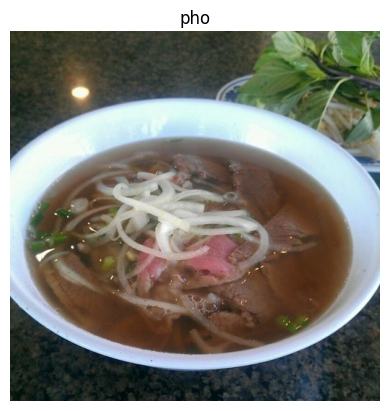

In [ ]:
for image, label in train_one_sample:
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis('off')

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you will often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors(different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` (or for mixed precision `float16`)
* For batches, TensforFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally perform better

With these points in mind, I have got few things I can tackle with a preprocessing function.

Since I am going to be using EfficientNetBX pretrained model from keras, I do not need to rescale our data

In [13]:
# Make a function for preprocessing images
def preprocess_image(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to [image_shape, image_shape, color_channel]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255. # Not required with EfficientNetBX models from tf.keras.applications

  return tf.cast(image, tf.float32), label

In [14]:
# Preprocess single sample image and check the outputs
preprocessed_image = preprocess_image(image, label)[0]
print(f"Image before preprocessing: {image[:2]}\nShape: {image.shape}\nDatatype: {image.dtype}\n\n")
print(f"Image before preprocessing: {preprocessed_image[:2]}\nShape: {preprocessed_image.shape}\nDatatype: {preprocessed_image.dtype}\n\n")

Image before preprocessing: [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]
Shape: (512, 512, 3)
Datatype: <dtype: 'uint8'>


Image before preprocessing: [[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.7398     3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622465]
  [48.928574  21.928572   4.9285717]]]
Shape: (224, 224, 3)
Datatype: <dtype: 'float32'>




#### Batch and prepare dataset

In [15]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#### Create modelling callbacks:
* TensorBoard callback to log training results
* ModelCheckpoint callback to save model's progress after feature extraction
* EarlyStopping callback to stop model training after it reaches highest* accuracy within threshold

In [20]:
# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoints/model_feature_extraction.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=0
)

# Create EarlyStoppingPoint callback
es_callback = EarlyStopping(
    monitor='val_loss',
    patience=5
)

## Setup mixed precision training: https://www.tensorflow.org/guide/mixed_precision

* Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [21]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Build feature extraction model

In [22]:
# Create base model
input_shape = (*IMAGE_SIZE, 3)
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in
x = base_model(inputs, training=False) # make sure layers which should be in inference
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
for layer in model.layers:
  print(f"{layer.name, layer.trainable, layer.dtype, layer.dtype_policy}")

('input_layer', True, 'float32', <Policy "float32">)
('efficientnetb0', False, 'float32', <Policy "mixed_float16">)
('global_average_pooling2d', True, 'float32', <Policy "mixed_float16">)
('dense', True, 'float32', <Policy "mixed_float16">)
('softmax_float32', True, 'float32', <Policy "float32">)


In [ ]:
# Check the dtype of attributes of base model layer
for layer in model.layers[1].layers[:20]:
  print(f"{layer.name, layer.trainable, layer.dtype, layer.dtype_policy}")

('input_1', False, 'float32', <Policy "float32">)
('rescaling', False, 'float32', <Policy "mixed_float16">)
('normalization', False, 'float32', <Policy "mixed_float16">)
('rescaling_1', False, 'float32', <Policy "mixed_float16">)
('stem_conv_pad', False, 'float32', <Policy "mixed_float16">)
('stem_conv', False, 'float32', <Policy "mixed_float16">)
('stem_bn', False, 'float32', <Policy "mixed_float16">)
('stem_activation', False, 'float32', <Policy "mixed_float16">)
('block1a_dwconv', False, 'float32', <Policy "mixed_float16">)
('block1a_bn', False, 'float32', <Policy "mixed_float16">)
('block1a_activation', False, 'float32', <Policy "mixed_float16">)
('block1a_se_squeeze', False, 'float32', <Policy "mixed_float16">)
('block1a_se_reshape', False, 'float32', <Policy "mixed_float16">)
('block1a_se_reduce', False, 'float32', <Policy "mixed_float16">)
('block1a_se_expand', False, 'float32', <Policy "mixed_float16">)
('block1a_se_excite', False, 'float32', <Policy "mixed_float16">)
('block1a

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model
2. Fine-tune some of the frozen layers

In [23]:
# Feature extraction model with callbacks
hist_101_food_calsses_feature_extract = model.fit(
    train_data,
    validation_data=test_data,
    validation_steps=(0.15*len(test_data)),
    epochs=3,
    callbacks=[
        create_tensorboard_callback(dir_name='training_logs', experiment_name='effnetb0_food_101'),
        model_checkpoint,
        es_callback
    ]
)

Saving TensorBoard log files to: training_logs/effnetb0_food_101/20230501-162053
Epoch 1/3
2368/2368 [==============================] - 202s 78ms/step - loss: 1.7138 - accuracy: 0.5835 - val_loss: 1.1244 - val_accuracy: 0.7004
Epoch 2/3
2368/2368 [==============================] - 188s 78ms/step - loss: 1.2007 - accuracy: 0.6886 - val_loss: 1.0345 - val_accuracy: 0.7159
Epoch 3/3
2368/2368 [==============================] - 178s 74ms/step - loss: 1.0549 - accuracy: 0.7246 - val_loss: 0.9948 - val_accuracy: 0.7203


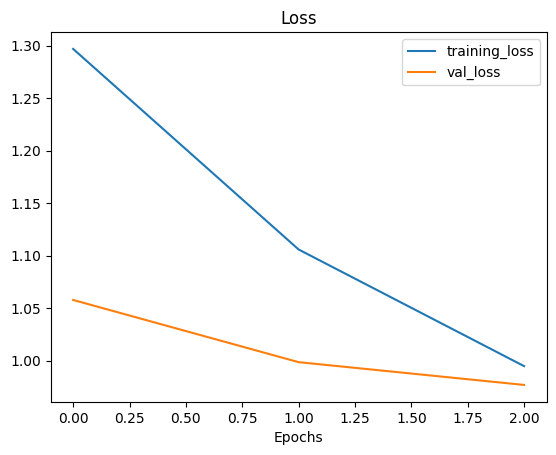

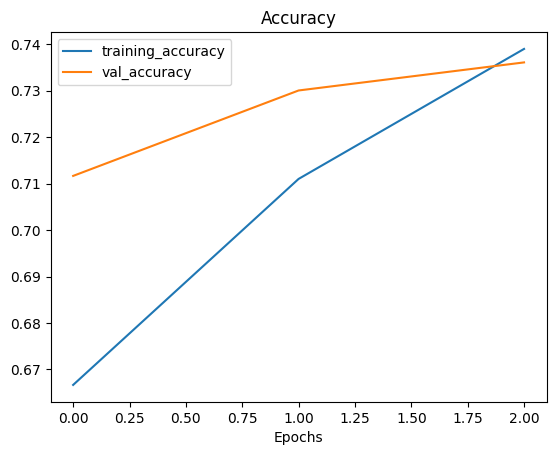

In [ ]:
# Plot model performance
plot_loss_curves(hist_101_food_calsses_feature_extract)

## Fine tune the model by unfreezing base model layers

In [24]:
# Unfreeze last 5 layers of base model
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

# Re-compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d_1 True
dense_1 True
softmax_float32 True


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-train

In [25]:
# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoints/food_vision_big_fine_tuned.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=0
)

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Fine tuning epochs
fine_tune_epochs = 5

# Fit the fine tuned model
hist_101_food_calsses_fine_tuning = model.fit(
    train_data,
    validation_data=test_data,
    validation_steps=(0.15*len(test_data)),
    epochs=fine_tune_epochs,
    initial_epoch=hist_101_food_calsses_feature_extract.epoch[-1],
    callbacks=[
        create_tensorboard_callback(dir_name='training_logs', experiment_name='effnetb0_food_101_fine_tuned'),
        model_checkpoint,
        es_callback
    ]
)

Saving TensorBoard log files to: training_logs/effnetb0_food_101_fine_tuned/20230501-163056
Epoch 3/5
2368/2368 [==============================] - 195s 77ms/step - loss: 0.8775 - accuracy: 0.7676 - val_loss: 0.9079 - val_accuracy: 0.7458
Epoch 4/5
2368/2368 [==============================] - 184s 77ms/step - loss: 0.7538 - accuracy: 0.8000 - val_loss: 0.8911 - val_accuracy: 0.7487
Epoch 5/5
2368/2368 [==============================] - 184s 77ms/step - loss: 0.6666 - accuracy: 0.8237 - val_loss: 0.8801 - val_accuracy: 0.7534


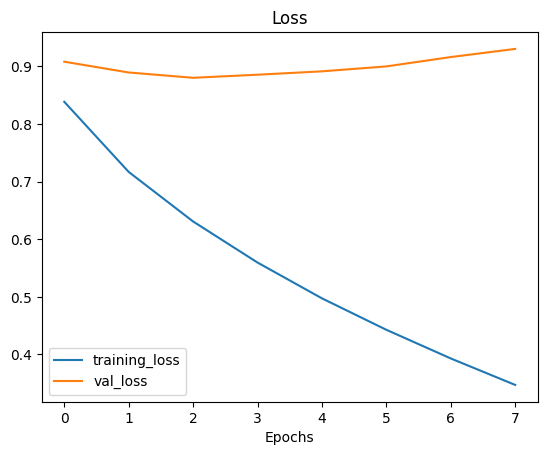

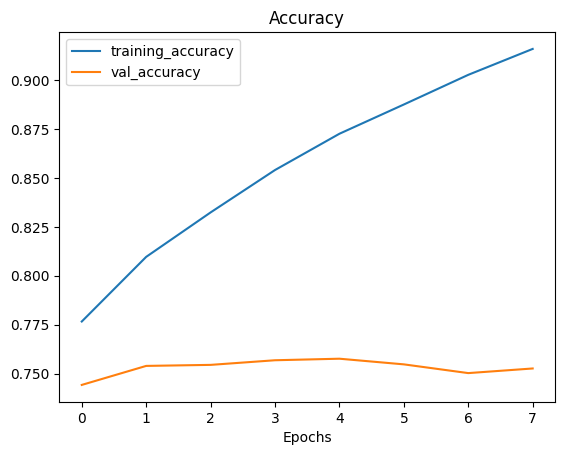

In [ ]:
# Plot fine tuned model performance
plot_loss_curves(hist_101_food_calsses_fine_tuning)

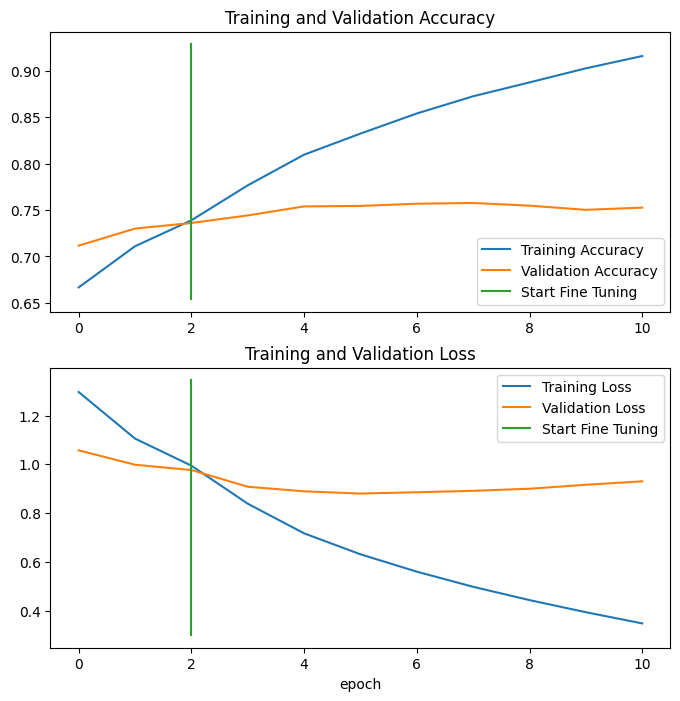

In [ ]:
# Compare feature extraction vs fine tuned models
compare_historys(original_history=hist_101_food_calsses_feature_extract,
                 new_history=hist_101_food_calsses_fine_tuning,
                 initial_epochs=3)

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 66s 83ms/step - loss: 0.9303 - accuracy: 0.7561


[0.9302846789360046, 0.7560791969299316]

In [ ]:
# # Upload experiment results to TensorBoard
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot

Visit following link to view tensorboard: https://tensorboard.dev/experiment/zza1tN5qRjuJH2Rhp3eCPg/#scalars

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 62s 79ms/step


In [ ]:
pred_probs

array([[5.5400342e-05, 3.2705411e-03, 7.9979734e-05, ..., 1.8809430e-06,
        3.2130737e-04, 1.1820237e-04],
       [1.6552884e-05, 6.3549280e-08, 1.7104055e-08, ..., 1.5080576e-01,
        3.8544588e-08, 6.8857764e-07],
       [6.1414738e-07, 8.2072920e-01, 2.8160074e-10, ..., 1.4079150e-09,
        1.6624208e-08, 3.3916442e-07],
       ...,
       [1.0471766e-06, 4.9748383e-08, 1.0636672e-06, ..., 5.1466310e-03,
        1.3657759e-06, 2.8465211e-06],
       [3.1943577e-09, 3.0544925e-08, 1.5879849e-07, ..., 8.7881421e-07,
        4.2077406e-08, 1.3718096e-06],
       [3.0181537e-09, 7.3123175e-08, 7.3387452e-10, ..., 3.1945149e-08,
        6.1225285e-07, 3.0721349e-08]], dtype=float32)

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy()) # append the index which has the largest value (labels are sparse)

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## It is hard to desipher this confusion matrix, It would be better to create a dataframe where model is most confident and making misclassification to get an insight how we could make an improvement

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [ ]:
classification_report_dict

{'0': {'precision': 0.018115942028985508,
  'recall': 0.02,
  'f1-score': 0.019011406844106463,
  'support': 250},
 '1': {'precision': 0.00816326530612245,
  'recall': 0.008,
  'f1-score': 0.00808080808080808,
  'support': 250},
 '2': {'precision': 0.00881057268722467,
  'recall': 0.008,
  'f1-score': 0.00838574423480084,
  'support': 250},
 '3': {'precision': 0.009478672985781991,
  'recall': 0.008,
  'f1-score': 0.008676789587852495,
  'support': 250},
 '4': {'precision': 0.007751937984496124,
  'recall': 0.008,
  'f1-score': 0.007874015748031496,
  'support': 250},
 '5': {'precision': 0.018656716417910446,
  'recall': 0.02,
  'f1-score': 0.0193050193050193,
  'support': 250},
 '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '7': {'precision': 0.013986013986013986,
  'recall': 0.016,
  'f1-score': 0.01492537313432836,
  'support': 250},
 '8': {'precision': 0.004739336492890996,
  'recall': 0.004,
  'f1-score': 0.004338394793926247,
  'support': 250},
 '9': {

In [ ]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
62,macaroni_and_cheese,0.024490
73,panna_cotta,0.024341
17,cheese_plate,0.023211
83,red_velvet_cake,0.022099
47,gnocchi,0.021097
...,...,...
39,foie_gras,0.000000
9,breakfast_burrito,0.000000
60,lobster_bisque,0.000000
59,lasagna,0.000000


In [ ]:
f1_scores['f1-score'].max(), f1_scores['f1-score'].min()

(0.02448979591836735, 0.0)

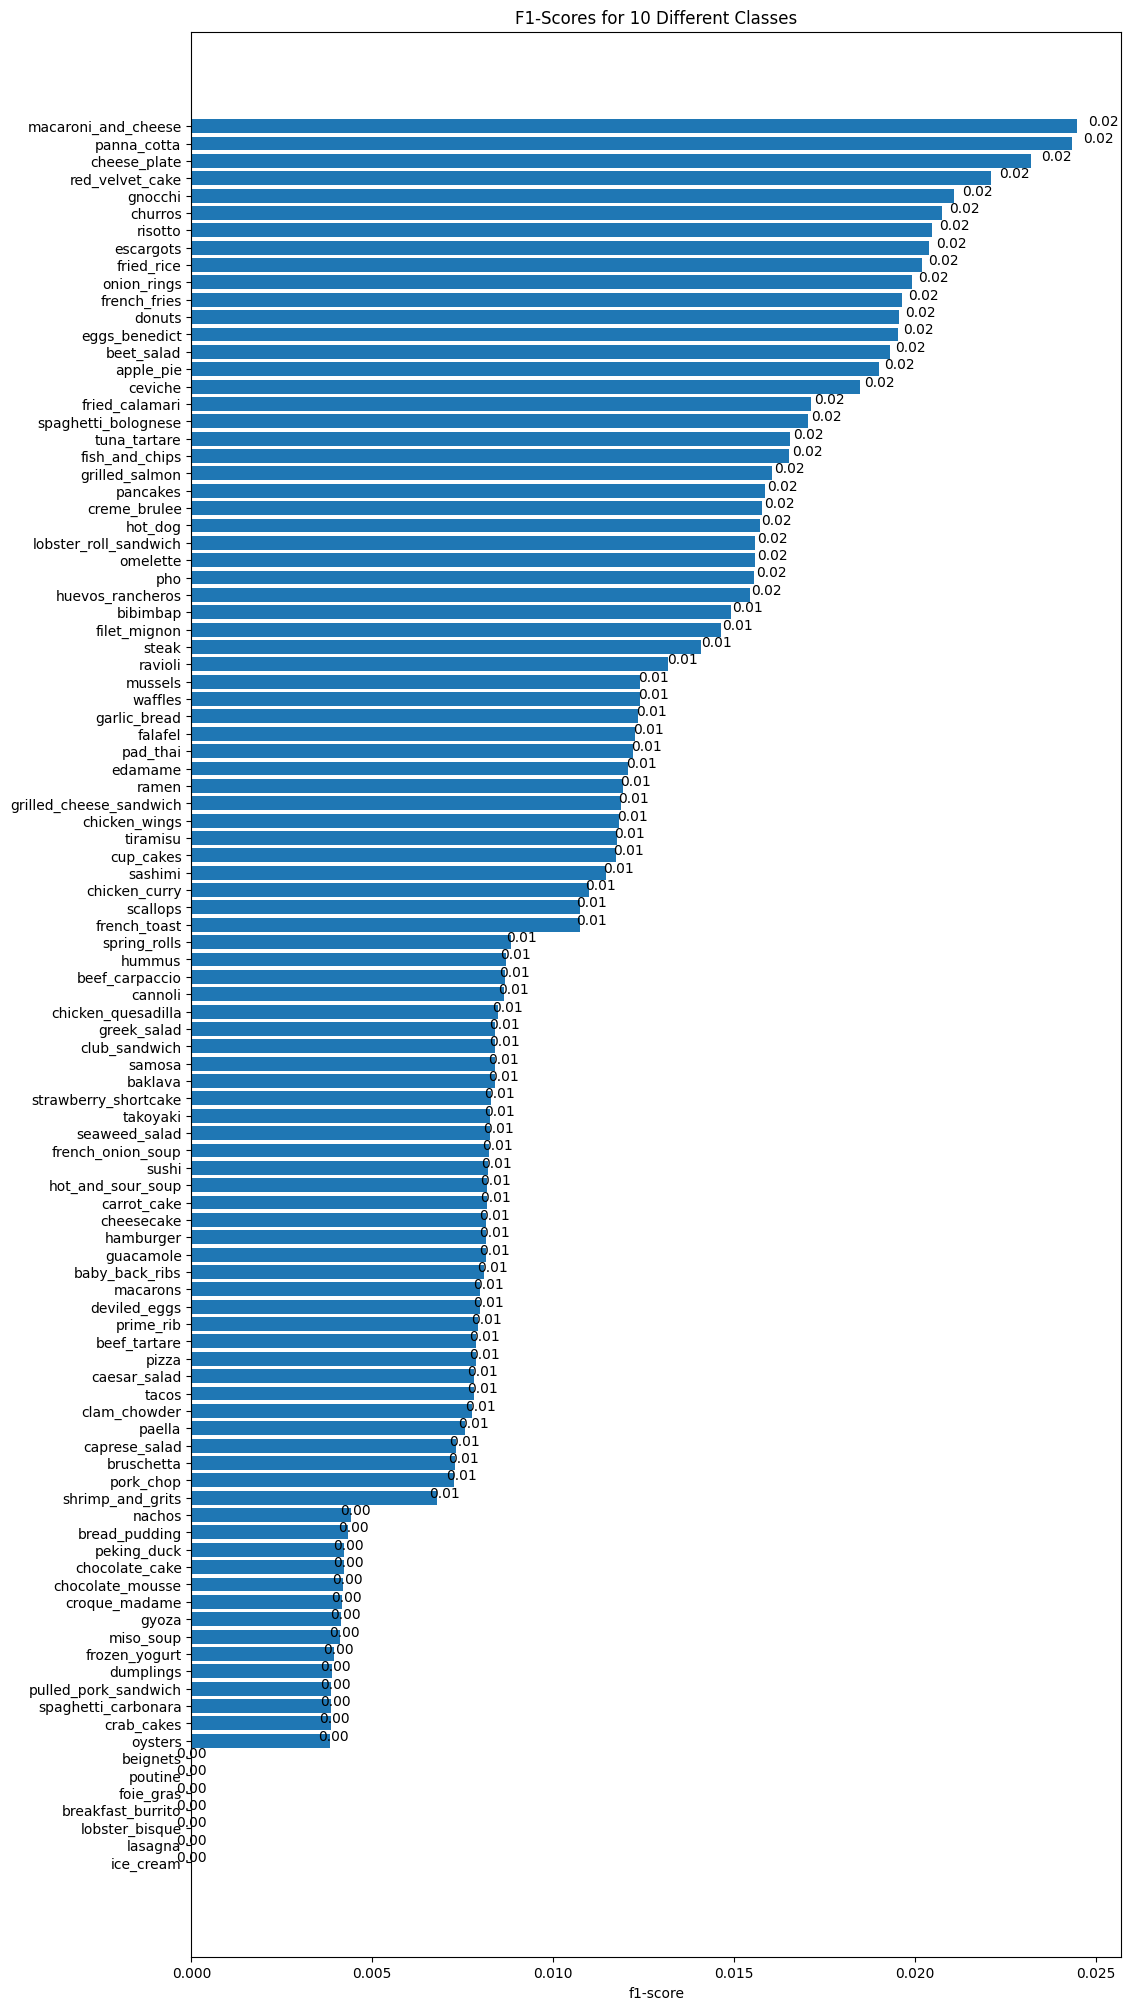

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
# Create a dataframe out of current prediction data for analysis
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,42,37,0.546807,french_toast,filet_mignon
1,57,83,0.671260,hummus,red_velvet_cake
2,46,1,0.820729,garlic_bread,baby_back_ribs
3,69,36,0.386600,oysters,falafel
4,100,62,0.559024,waffles,macaroni_and_cheese


In [ ]:
pred_df['check'] = pred_df['y_true_classname'] != pred_df['y_pred_classname']
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,check
0,42,37,0.546807,french_toast,filet_mignon,True
1,57,83,0.671260,hummus,red_velvet_cake,True
2,46,1,0.820729,garlic_bread,baby_back_ribs,True
3,69,36,0.386600,oysters,falafel,True
4,100,62,0.559024,waffles,macaroni_and_cheese,True


In [ ]:
pred_df['check'].value_counts(normalize=True)

True     0.989228
False    0.010772
Name: check, dtype: float64

In [ ]:
pred_probs.max(axis=1)

array([0.5468071 , 0.67126006, 0.8207292 , ..., 0.5845043 , 0.9967193 ,
       0.9163375 ], dtype=float32)